![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

# Wasserstein Barycenters using Mosek

Wasserstein Distance is a way to measure the distance between two probabilty distributions. It allows to summarize, compare, match and reduce the dimensionality of the emprical probability measures to carry out some machine learning fundamentals.

Wasserstein distance of order $p$ between two probabilty distributions $\mu$ and $\upsilon$ is defined as:
<br>
<br>
$$W_p(\mu,\upsilon)$$

If the distributions are discrete $W_p(\mu,\upsilon)$ is equilavent to the following LP model:
<br>
<br>
$$ \mbox{minimize} \quad \sum_{i=1}\sum_{j=1} D(X_i,Y_j)^p\pi_{ij}$$
<br>
$$ \mbox{st.} \quad \sum_{j=1} \pi_{ij} = \mu_i , \quad i = 1,2,..n $$
<br>
$$ \quad \sum_{i=1} \pi_{ij} = \upsilon_j, \quad j = 1,2,..m $$
<br>
$$ \pi_{ij} \geq 0, \quad \forall_{i,j}$$
<br>
where $D(X_i,Y_j)$ is the distance function.

There are more efficient ways to approximate this metric but LP approach will be applied in order to compare the performance and modeling structure of Fusion, Pyomo and CVXPY.

## Wasserstein Barycenter

Wasserstein barycenter problem involves all Wasserstein distances from one to many measures. Given measures $\upsilon_1,\ldots,\upsilon_N$ we want to find the measure which minimizes the sum of distances to the given measures, that is solve the problem:
$$ \mbox{minimize}_\mu\sum_{i=1} \lambda_i W_p(\mu,\upsilon_i) $$
for some fixed system $\lambda_i $ of weights of distances to specific distributions that satisfies $$\sum_{i=1}\lambda_i = 1.$$
For simplicity uniform weights are used in this problem. Then the barycenters problem becomes:
$$ \mbox{minimize}_\mu \frac1N \sum_{i=1}^{N} W_p(\mu,\upsilon_i). $$

In this problem, Wasserstein Barycenter of One's are visualized using images with size $28x28$ using $20$ handwriten '1' digits from MNIST database http://yann.lecun.com/exdb/mnist/. Computations are carried out by Intel(R) Xeon(R) CPU E5-2687W v4 @ 3.00GHz processor. Similar experiments are performed by Cuturi and Doucet in http://proceedings.mlr.press/v32/cuturi14.pdf.

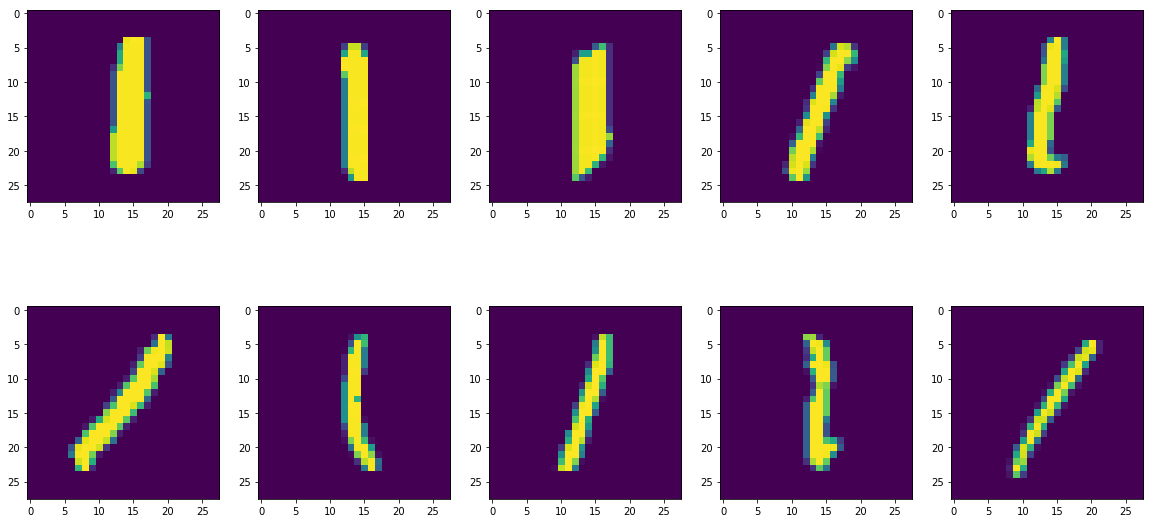

In [1]:
import struct
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#Define the number of images for the barycenter calculation
n=20

#Read the images from the file
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
data = read_idx('train-images.idx3-ubyte')
labels = read_idx('train-labels.idx1-ubyte')
#Select the images
ones = data[labels == 1]
train_1 = ones[:n]

plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(ones[np.random.randint(0,ones.shape[0])])

## Barycenters using Mosek Fusion

The final barycenter problem is as follows. We choose $p=2$.
<br>
<br>
$$ \mbox{minimize} \quad \frac1N \sum_{k=1}^{N} t_k \quad $$
<br>
$$ \mbox{st.} \quad t_k \geq \sum_{i=1}\sum_{j=1} D(X_i,Y_j)^2\pi_{ij}^k \quad \forall_{k} \quad (1)$$
<br>
$$  \quad \sum_{j=1} \pi_{ij}^{k} = \mu_i , \quad \forall_{k,i} \quad (2)$$
<br>
$$ \quad \sum_{i=1} \pi_{ij}^{k} = \upsilon_j^{k}, \quad \forall_{k,j} \quad (3) $$
<br>
$$ \pi_{ij}^{k} \geq 0 \quad \forall_{k,i,j}, \quad \mu_i \geq 0 \quad \forall_i$$
<br>
where $D(X_i,Y_j)$ is the Euclidean distance between pixels and $N$ is the number of samples.

In [2]:
from mosek.fusion import *
import time
import sys
class Wasserstein_Fusion:
    
    def __init__(self):
        self.time = 0.0
        self.M = Model('Wasserstein')
        self.result = None
    
    
    def single_pmf(self, data = None, img=False):
        
        ''' Takes a image or array of images and extracts the probabilty mass function'''
        
        if not img:
            v=[]
            for image in data:
                arr = np.asarray(image).ravel(order='K')
                v.append(arr/np.sum(arr))
        else:
            v = np.asarray(data).ravel(order='K')
            v = v/np.sum(v)
        return v
    
    def ms_distance(self, m ,n, constant=False):
        
        ''' Squared Euclidean distance calculation between the pixels '''
        
        if constant:
            d = np.ones((m,m))
        else:
            d = np.empty((m,m))
            coor = []
            for i in range(n):
                for j in range(n):
                    coor.append(np.array([i,j]))
            for i in range(m):
                for j in range(m):
                    d[i][j] = np.linalg.norm(coor[i]-coor[j])**2
        return d
    
    def Wasserstein_Distance(self, bc ,data, img = False):
        
        ''' Calculation of wasserstein distance between a barycenter and an image by solving the minimization problem '''
    
        v = np.array(self.single_pmf(data, img))
        n = v.shape[0]
        d = self.ms_distance(n,data.shape[1])
        with Model('Wasserstein') as M:
            #Add variable
            pi = M.variable('pi',[n,n], Domain.greaterThan(0.0))
            
            #Add constraints
            M.constraint('c1' , Expr.sum(pi,0), Domain.equalsTo(v))
            M.constraint('c2' , Expr.sum(pi,1), Domain.equalsTo(bc))
            
            M.objective('Obj.' , ObjectiveSense.Minimize, Expr.dot(d, pi))
            
            M.solve()
            objective = M.primalObjValue()
            
        return objective
    
    def Wasserstein_BaryCenter(self,data):
        
        M = self.M
        start_time = time.time()
        k = data.shape[0]
        v = np.array(self.single_pmf(data))
        n = v.shape[1]
        d = self.ms_distance(n,data.shape[1])
        
        #Add variables   
        mu = M.variable('Mu', n, Domain.greaterThan(0.0))  
        pi = (M.variable('Pi', [k,n,n] , Domain.greaterThan(0.0)))
        t = (M.variable('t', k , Domain.greaterThan(0.0)))
                
        #Add constraints    
        #Constraint (1)
        M.constraint('A', Expr.sub(t , Expr.mul(Expr.reshape(pi.asExpr(), k, n*n) , d.ravel())), Domain.greaterThan(0.0))
        #Constraint (2)
        M.constraint('B', Expr.sub(Expr.sum(pi,1) , Var.repeat(mu,1,k).transpose()), Domain.equalsTo(0.0))
        #Constraint (3)
        M.constraint('C', Expr.sum(pi,2), Domain.equalsTo(v))
            
        M.objective('Obj' , ObjectiveSense.Minimize, Expr.sum(Expr.mul(t, 1/k)))
        
        M.setLogHandler(sys.stdout)
        M.solve()
        self.result = mu.level()
        self.objective = M.primalObjValue()
        self.time = time.time() - start_time
        
        return self.result
        
        
    def reset(self):
        self.M = Model('Wasserstein')
    

In [3]:
fusion_model = Wasserstein_Fusion()
f_bc = fusion_model.Wasserstein_BaryCenter(train_1)
print('\nTime Spent to solve problem with Fusion: \n {0}'.format(fusion_model.time))
print('Time Spent in solver: \n {0}'.format(fusion_model.M.getSolverDoubleInfo("optimizerTime")))
print('The average Wasserstein distance between digits and the barycenter: \n {0}'.format(fusion_model.objective))

Problem
  Name                   : Wasserstein     
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 31380           
  Cones                  : 0               
  Scalar variables       : 12293925        
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.24            
Lin. dep.  - number                 : 19              
Presolve terminated. Time: 5.42    
GP based matrix reordering started.
GP based matrix reordering terminated.
Problem
  Name                   : Wasserstein     
  Objective sense   

Time Spent to solve problem with Fusion:<br>
 71.99116826057434<br>
Time Spent in solver: <br>
 56.61195707321167<br>
The average Wasserstein distance between digits and the barycenter: <br>
 3.1148587717952356<br>

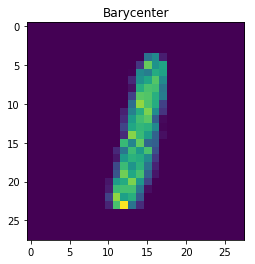

In [4]:
fus_bc = np.reshape(f_bc,(28,28))
plt.imshow(fus_bc)
plt.title('Barycenter')
plt.show()

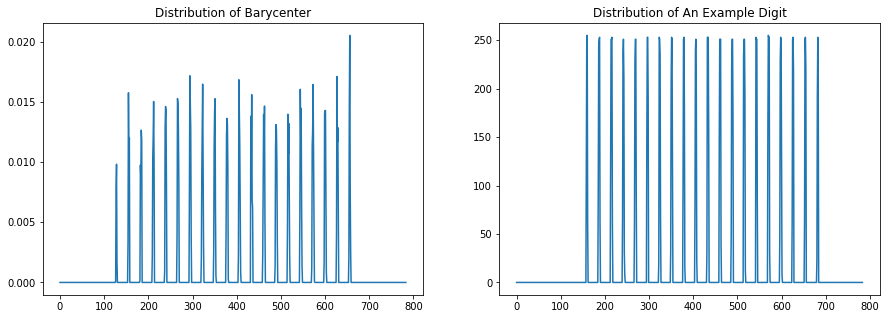

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(fus_bc).ravel().T)
plt.title('Distribution of Barycenter')
plt.subplot(1,2,2)
plt.plot(train_1[0].ravel())
plt.title('Distribution of An Example Digit')
plt.show()

## Modeling the same problem with Pyomo

The same problem is formulated using Pyomo and solved using Mosek. Unlike Fusion Pyomo requires rules and summations to formulate the problem.

In [6]:
import pyomo.environ as pyo
import time
class Wasserstein_Pyomo:
    
    def __init__(self):
        self.time = 0.0
        self.result = None
        self._solver = 'mosek_direct'
        self.M = pyo.ConcreteModel()
    
    
    def single_pmf(self, data = None, img=False):
        
        ''' Takes a image or array of images and extracts the probabilty mass function'''
        
        if not img:
            v=[]
            for image in data:
                arr = np.asarray(image).ravel(order='K')
                v.append(arr/np.sum(arr))
        else:
            v = np.asarray(data).ravel(order='K')
            v = v/np.sum(v)
        return v
    
    def ms_distance(self, m ,n, constant=False):
        
        ''' Squared Euclidean distance calculation between the pixels '''
        
        if constant:
            d = np.ones((m,m))
        else:
            d = np.empty((m,m))
            coor = []
            for i in range(n):
                for j in range(n):
                    coor.append(np.array([i,j]))
            for i in range(m):
                for j in range(m):
                    d[i][j] = np.linalg.norm(coor[i]-coor[j])**2
        return d
    
    def Wasserstein_BaryCenter(self,data):
        
        ''' Calculation of wasserstein barycenter of given images by solving the minimization problem '''
        
        M = self.M
        k = data.shape[0]
        v = np.array(self.single_pmf(data))
        n = v.shape[1]
        d = self.ms_distance(n,data.shape[1])
        
        #Define indices
        M.i = range(n)
        M.j = range(n)
        M.k = range(k)
        
        #Add variables
        M.pi = pyo.Var(M.k, M.i, M.j, domain = pyo.NonNegativeReals)
        M.mu = pyo.Var(M.i, domain = pyo.NonNegativeReals)
        M.t = pyo.Var(M.k, domain = pyo.NonNegativeReals)
        
        M.obj = pyo.Objective(expr = sum(M.t[k] for k in M.k)/k, sense= pyo.minimize)
        
        #Define constraint rules
        def c3_rule(model, k, j): #Rule for Constraint (3)
            return sum(model.pi[k,i,j] for i in model.i) == v[k][j]
        def c2_rule(model, k, i): #Rule for Constraint (2)
            return sum(model.pi[k,i,j] for j in model.j) == model.mu[i]
        def c1_rule(model, k):    #Rule for Constraint (1)
            return sum(d[i][j]*model.pi[k,i,j] for i in model.i for j in model.j) <= model.t[k]
        
        # Add Constraints
        M.c3 = pyo.Constraint(M.k, M.j , rule = c3_rule)
        M.c2 = pyo.Constraint(M.k, M.i , rule = c2_rule)
        M.c1 = pyo.Constraint(M.k, rule = c1_rule)
        
        return M
    
    def run(self,data):
        start_time = time.time()
        model = self.Wasserstein_BaryCenter(data)
        opt = pyo.SolverFactory(self._solver)
        self.result = opt.solve(model, tee = True)
        self.time = time.time() - start_time
        bc = []
        [bc.append(model.mu[i]()) for i in range(data.shape[1]*data.shape[2])]
        return np.array(bc)
    
    def reset(self):
        self.M = pyo.ConcreteModel()
    

In [7]:
pyomo_model = Wasserstein_Pyomo()
p_bc = pyomo_model.run(train_1)
print('\nTime spent to solve problem with Pyomo: \n {0}'.format(pyomo_model.time))
print('Time spent in solver: \n {0}'.format(pyomo_model.result.solver.wallclock_time))
print('The average Wasserstein distance between digits and the barycenter: \n {0}'.format(pyomo_model.M.obj()))

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 31380           
  Cones                  : 0               
  Scalar variables       : 12293924        
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.52            
Lin. dep.  - number                 : 19              
Presolve terminated. Time: 9.79    
GP based matrix reordering started.
GP based matrix reordering terminated.
Problem
  Name                   :                 
  Objective sense   

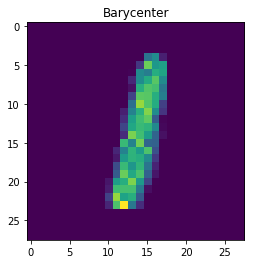

In [8]:
pyo_bc = np.reshape(p_bc, (28,28))
#print('Visualization of the barycenter:')
plt.imshow(pyo_bc)
plt.title('Barycenter')
plt.show()

### Modeling the same problem with CVXPY

In [9]:
import cvxpy as cp
import time
class Wasserstein_CVXPY:
    
    def __init__(self):
        self.time = 0.0
        self.result = None
        self.prob = None

    def single_pmf(self, data = None, img=False):
        
        ''' Takes a image or array of images and extracts the probabilty mass function'''
        
        if not img:
            v=[]
            for image in data:
                arr = np.asarray(image).ravel(order='K')
                v.append(arr/np.sum(arr))
        else:
            v = np.asarray(data).ravel(order='K')
            v = v/np.sum(v)
        return v
    
    def ms_distance(self, m ,n, constant=False):
        
        ''' Squared Euclidean distance calculation between the pixels '''
        
        if constant:
            d = np.ones((m,m))
        else:
            d = np.empty((m,m))
            coor = []
            for i in range(n):
                for j in range(n):
                    coor.append(np.array([i,j]))
            for i in range(m):
                for j in range(m):
                    d[i][j] = np.linalg.norm(coor[i]-coor[j])**2
        return d
    
    def Wasserstein_Distance(self, bc ,data, img = False):
        
        ''' Calculation of wasserstein distance between a barycenter and an image by solving 
            the minimization problem '''
    
        v = np.array(self.single_pmf(data, img))
        n = v.shape[0]
        d = self.ms_distance(n,data.shape[1])
        
        pi = cp.Variable((n,n), nonneg=True)
        obj = cp.Minimize((np.ones(n).T @ cp.multiply(d,pi) @ np.ones(n)))
        
        Cons=[]
        Cons.append((np.ones(n) @ pi).T == bc)
        Cons.append((pi @ np.ones(n)) == v)
        
        prob = cp.Problem(obj, constraints= Cons)
        
        return prob.solve(solver=cp.MOSEK, verbose = True)
        
    def Wasserstein_BaryCenter(self,data):
        
        ''' Calculation of wasserstein barycenter of given images by solving the minimization problem '''
        
        start_time = time.time()
        k = data.shape[0]
        v = np.array(self.single_pmf(data))
        n = v.shape[1]
        d = self.ms_distance(n,data.shape[1])
        
        #Add variables
        pi= []
        t= []
        mu = cp.Variable(n, nonneg = True)
        for i in range(k):
            pi.append(cp.Variable((n,n), nonneg = True))
            t.append(cp.Variable(nonneg = True))
            
        obj = cp.Minimize(np.sum(t)/k)
        
        #Add constraints
        Cons=[]
        for i in range(k):
            Cons.append( t[i] >= np.ones(n).T @  cp.multiply(d,pi[i]) @ np.ones(n) ) #Constraint (1)
            Cons.append( (np.ones(n) @ pi[i]).T == mu)                               #Constraint (2)
            Cons.append( (pi[i] @ np.ones(n)) == v[i])                            #Constraint (3)
            
        self.prob = cp.Problem(obj, constraints= Cons)
        self.result = self.prob.solve(solver=cp.MOSEK,verbose = True)
        self.time = time.time() - start_time
        
        return mu.value
    
    def reset(self):
        self.prob = None
        self.result = None


In [10]:
cvxpy_model = Wasserstein_CVXPY()
result = cvxpy_model.Wasserstein_BaryCenter(train_1)
print('\nTime Spent to solve problem with CVXPY: \n {0}'.format(cvxpy_model.time))
print('Time Spent in solver: \n {0}'.format(cvxpy_model.prob.solver_stats.solve_time))
print('The average Wasserstein distance between digits and the barycenter: \n {0}'.format(cvxpy_model.result))



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 12325304        
  Cones                  : 0               
  Scalar variables       : 12293924        
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
GP based matrix reordering started.
GP based matrix reordering terminated.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 12325304        
  Cones                  : 0               
  Scalar variables       : 12293924        
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 24              
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 17

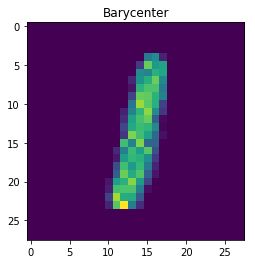

In [11]:
plt.imshow(np.reshape(result.squeeze(), (28,28)))
plt.title('Barycenter')
plt.show()

Also, when the log data from Mosek is investigated the number of variables are same for each modeling language. However, while Pyomo and Fusion having same number of constraints CVXPY has a lot of extra constraints that resulted from nonnegativity of the variables.

## Comparison of Modeling Languages

### Time to solve the problem

In [12]:
print('Total Time:')
print('Fusion: {0}'.format(fusion_model.time))
print('Pyomo : {0}'.format(pyomo_model.time))
print('CVXPY : {0}'.format(cvxpy_model.time))
print('\nTime spent in the solver:')
print('Fusion: {0}'.format(fusion_model.M.getSolverDoubleInfo("optimizerTime")))
print('Pyomo : {0}'.format(pyomo_model.result.solver.wallclock_time))
print('CVXPY : {0}'.format(cvxpy_model.prob.solver_stats.solve_time))

Total Time:
Fusion: 70.28409123420715
Pyomo : 918.1947894096375
CVXPY : 125.29915714263916

Time spent in the solver:
Fusion: 54.830564975738525
Pyomo : 60.200079917907715
CVXPY : 69.51178908348083


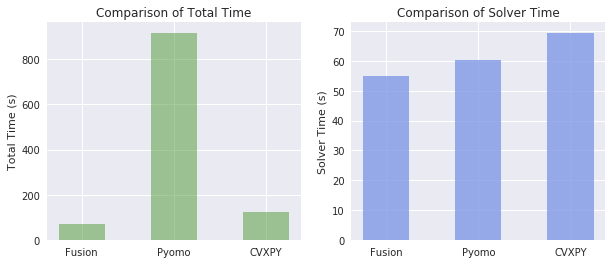

In [13]:
plt.style.use('seaborn')
plt.figure(figsize=(10,4))

total_t = [fusion_model.time, pyomo_model.time, cvxpy_model.time]
solver_t = [fusion_model.M.getSolverDoubleInfo("optimizerTime"), pyomo_model.result.solver.wallclock_time, cvxpy_model.prob.solver_stats.solve_time]

#Total time plot
plt.subplot(1,2,1)
plt.bar(['Fusion', 'Pyomo', 'CVXPY'], height= total_t,
        width=0.5, color=(0.3, 0.6, 0.2, 0.5))
plt.ylabel("Total Time (s)")
plt.title("Comparison of Total Time")

#Solver time plot
plt.subplot(1,2,2)
plt.bar(['Fusion', 'Pyomo', 'CVXPY'], height=solver_t,
        width=0.5, color=(0.5, 0.6, 0.9, 0.8))
plt.ylabel("Solver Time (s)")
plt.title("Comparison of Solver Time")
plt.show()

## Discussion

Apparently, **Fusion passes the model data to Mosek faster** than the other ones. CVXPY is close to Fusion but its solver time is longer, mainly due to presolve (for example CVXPY enters variable bounds as constraints). In terms of total time Pyomo is behind the others because all the transformations are made in Python, as opposed to Fusion and CVXPY which call a C library. However, this is a huge model with 31 thousand constraints and 12 million variables and the difference will not be that big for normal-sized models.

On the other hand, Fusion and CVXPY allow you to express model in vectorized form (using **matrix, vector** notation). Pyomo is mainly based on **sum expressions** that can be defined by **rule functions** which makes modelling much easier. Therefore the **time and effort spent on constructing the model in Pyomo was much smaller** than with  the other languages.

The decision of which one to use depends on the problem and the preferences of the user.

## CVXPY and Fusion on huge models

  $\quad$The plots above show the performance of the modeling languages for 20 images. It is also reasonable to test the behaivor of solving times as the model gets larger and larger. In order to make this test same problem is solved with 50 images by using CVXPY and Fusion.

In [14]:
n = 50
train_1 = ones[:n]
cvxpy_model.reset()
fusion_model.reset()

### CVXPY

In [15]:
res_cvx = cvxpy_model.Wasserstein_BaryCenter(train_1)
print('\nTime Spent to solve problem with CVXPY: \n {0}'.format(cvxpy_model.time))
print('Time Spent in solver: \n {0}'.format(cvxpy_model.prob.solver_stats.solve_time))
print('The average Wasserstein distance between digits and the barycenter: \n {0}'.format(cvxpy_model.result))



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 30812084        
  Cones                  : 0               
  Scalar variables       : 30733634        
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
GP based matrix reordering started.
GP based matrix reordering terminated.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 30812084        
  Cones                  : 0               
  Scalar variables       : 30733634        
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 24              
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 43

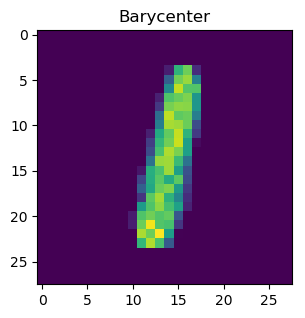

In [16]:
plt.style.use("default")
plt.figure(figsize=(3.3,3.3))
plt.imshow(np.reshape(res_cvx.squeeze(), (28,28)))
plt.title('Barycenter')
plt.show()

### Fusion

In [17]:
res_f = fusion_model.Wasserstein_BaryCenter(train_1)
print('\nTime Spent to solve problem with Fusion: \n {0}'.format(fusion_model.time))
print('Time Spent in solver: \n {0}'.format(fusion_model.M.getSolverDoubleInfo("optimizerTime")))
print('The average Wasserstein distance between digits and the barycenter: \n {0}'.format(fusion_model.objective))

Problem
  Name                   : Wasserstein     
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 78450           
  Cones                  : 0               
  Scalar variables       : 30733635        
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.84            
Lin. dep.  - number                 : 49              
Presolve terminated. Time: 16.23   
GP based matrix reordering started.
GP based matrix reordering terminated.
Problem
  Name                   : Wasserstein     
  Objective sense   

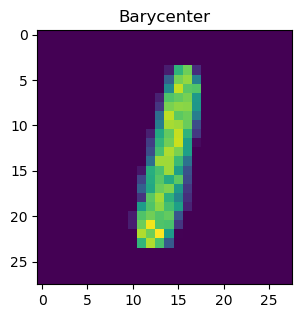

In [18]:
plt.figure(figsize=(3.3,3.3))
plt.imshow(np.reshape(res_f,(28,28)))
plt.title('Barycenter')
plt.show()

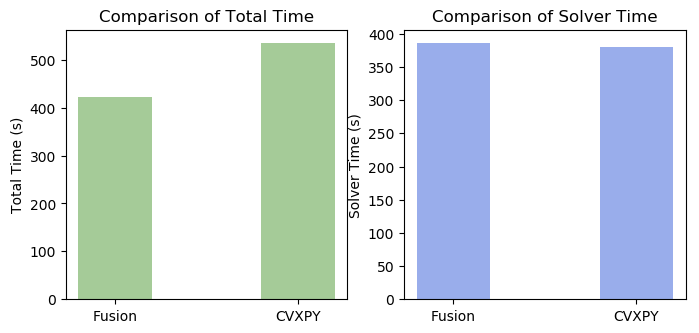

In [19]:
plt.figure(figsize=(8,3.5))

total_t50 = [fusion_model.time, cvxpy_model.time]
solver_t50 = [fusion_model.M.getSolverDoubleInfo("optimizerTime"), cvxpy_model.prob.solver_stats.solve_time]

#Total time plot
plt.subplot(1,2,1)
plt.bar(['Fusion', 'CVXPY'], height= total_t50,
        width=0.4, color=(0.3, 0.6, 0.2, 0.5))
plt.ylabel("Total Time (s)")
plt.title("Comparison of Total Time")

#Solver time plot
plt.subplot(1,2,2)
plt.bar(['Fusion','CVXPY'], height=solver_t50,
        width=0.4, color=(0.5, 0.6, 0.9, 0.8))
plt.ylabel("Solver Time (s)")
plt.title("Comparison of Solver Time")
plt.show()

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 